In [1]:
from SEAFU import *
from SEA_DATATOOLS import DATASET, DATASET_B

# Seasonal Adjustment

Author: Frank Ygnacio

Based on paper: _Covid-19 and Seasonal Adjustment, Abeln and Jacobs (July, 2022)_.

---

## Model 1: X-11 ARIMA

This model involves several steps, each of which combines time series analysis techniques for preprocessing, modeling, and adjusting the data. The steps are detailed below using mathematical notation.

### 1. Preprocessing:

1. **Handle outliers** in the original time series, $ Y_t $, where $ t $ indexes time. Outliers can be managed through exclusion, adjustment, or incorporation as external variables.

2. **Test for stationarity** and difference the series if necessary, to obtain a stationary series, $ Y'_t $, such that:
   $
   Y'_t = \Delta^d Y_t
   $
   where $ \Delta $ denotes the differencing operator and $ d $ is the order of differencing required to achieve stationarity.

3. **Prior adjustments** may be considered, including calendar adjustments or known effects.

### 2. ARIMA Modeling:

1. Determine the order $(p, d, q)$ of the ARIMA model using Autocorrelation Function (ACF), Partial Autocorrelation Function (PACF), and criteria like Akaike Information Criterion (AIC)/Bayesian Information Criterion (BIC).

2. Fit the ARIMA model to $ Y'_t $ to obtain the trend-cycle estimates, represented as:
   $
   ARIMA(p, d, q): (1 - \sum_{i=1}^{p} \phi_i L^i)(1 - L)^d Y_t = (1 + \sum_{j=1}^{q} \theta_j L^j) \varepsilon_t
   $
   where $ L $ is the lag operator, $ \phi_i $ are the autoregressive parameters, $ \theta_j $ are the moving average parameters, and $ \varepsilon_t $ is the error term.

### 3. X11 Procedure:

1. **Trend Extraction**:
   Apply a centered moving average to $ Y_t $ to estimate the trend-cycle component, $ T_t $.

2. **Seasonal Adjustment**:
   Calculate the seasonal component by dividing $ Y_t $ by $ T_t $, then compute period averages to get initial seasonal factors, $ S_t $.

3. **Seasonal Factor Normalization**:
   Normalize $ S_t $ so that their mean is 1.0.

4. **Final Seasonal Adjustment**:
   Adjust $ Y_t $ by dividing it by the normalized seasonal factors, to obtain the seasonally adjusted series, $ Y^{adj}_t $.

5. **Postprocessing** (if necessary):
   Apply additional adjustments as needed.

### 4. Forecasting:

1. Use the fitted ARIMA model to forecast future values, $ \hat{Y}_{t+h} $, where $ h $ is the forecast horizon.

2. Apply the X11 procedure to the extended series for future seasonal adjustments.

### 5. Output:

- The seasonally adjusted series, $ Y^{adj}_t $.
- (Optional) The de-trended series and seasonal factors for further analysis.
- (Optional) Forecasted values from the ARIMA model.

***

## Model 2: SLT

Season-Trend decomposition using LOESS (Locally Weighted Regression Smoother). The most relevant part of this model is the LOESS procedure.

### LOESS Procedure for $x = [1, 2, 3, 4, 5, 6]$ and $y = [3, 5, 8, 12, 18, 24]$, focusing on $x_i = 3$:

1. **Fitting Local Polynomials:**
   - Determine neighbors of $x_i = 3$ based on a 0.65 fraction, selecting 4 closest points ($x_{i-1} = 2$, $x_{i+1} = 4$, and $x_{i-2} = 1$, $x_{i+2} = 5$) for symmetry.

2. **Computing the Weights:**
   - Use the Tricube Weight Function: $w_j = (1 - |d|^3)^3$, where $d$ is the normalized distance to $x_i$. For immediate neighbors, the weights are computed as $w \approx 0.669921875$.

3. **Minimizing Weighted Least Squares:**
   - Aim to find $\beta_0$ and $\beta_1$ by minimizing $\sum w_j(y_j - \beta_0 - \beta_1x_j)^2$, using $\beta = (X^T W X)^{-1} X^T W y$. $X$ is the design matrix of ones and $x$ values, $W$ is a diagonal weight matrix, and $y$ is the vector of response values.

#### Example for Linear Regression:
Given data points $x = [2, 3, 4]$ and $y = [5, 8, 12]$ with weights $w = [0.669921875, 1, 0.669921875]$, construct matrix $A$ and vector $b$ from the weighted least squares formulation and solve for $\beta_0$ and $\beta_1$, resulting in the fitted model $y = -2.214 + 3.500x$.

4. **Robustness Iterations:**
   - Iteratively adjust weights based on residuals, decreasing the influence of outliers until convergence. This process iteratively improves fit and minimizes the impact of outliers.

5. **Resulting Smooth:**
   - The LOWESS curve is generated by applying the process across all $x_i$, producing a smoothed series that reflects the underlying trend while being less influenced by noise and outliers. This includes handling introduced outliers (e.g., an incorrect value at $x = 4$).

6. **Handling Outliers:**
   - Initial smoothing might inaccurately reflect trends at outlier points. Iterative reweighting, based on residuals, reduces their impact, leading to a smoothed series that better represents the underlying trend.

7. **Iterative Reweighting:**
   - Weights are adjusted using the bisquare weight function $w_i = \left(1 - \left(\frac{r_i}{6 \cdot MAD}\right)^2\right)^2$ for $|r_i| < 6 \cdot MAD$, where $r_i$ is the residual for the $i$th data point, and $MAD$ is the median absolute deviation of the residuals.

### Example of Outlier Adjustment:
- After initial smoothing, suppose residuals and $MAD$ for the dataset, with an introduced outlier, are computed. Weights for points with large residuals (e.g., the outlier at $x = 4$) are reduced. Iterative smoothing and weight adjustment continue until convergence, effectively minimizing the outlier's influence.

***

## Model 3: CAMPLET

The CAMPLET model is a seasonal adjustment method that decomposes a time series into its seasonal and non-seasonal components. Its main advantage lies in its ability to make adjustments without the need for revising historical data as new observations become available. Here's a detailed explanation of how it works, focusing on how it obtains the seasonal component and handles new observations:

### 1. Initial Seasonal Component Estimation

The CAMPLET model starts by estimating the initial seasonal component of the time series. This process involves:

- **Dividing the Time Series into Cycles**: Assuming the time series has a known periodicity (e.g., monthly data with a 12-month cycle), the series is divided into cycles based on this periodicity.

- **Calculating Period Averages**: For each period within the cycle (e.g., each month in the year), the model calculates the average value of the time series observations that fall into that period over several cycles. This gives an array of average values, one for each period in the cycle.

- **Determining the Overall Average**: The model calculates the overall average of the time series for the complete cycles.

- **Estimating Initial Seasonal Component**: The initial seasonal component for each period is obtained by subtracting the overall average from the period averages. This results in a set of initial seasonal factors that reflect the average seasonal effect for each period within the cycle.

Mathematically, if $y_t$ is the observation at time $t$, and there are $P$ periods in a cycle (e.g., $P = 12$ for monthly data), the initial seasonal component $S_i$ for period $i$ is calculated as:
$S_i = \bar{y}_i - \bar{y}$
where $\bar{y}_i$ is the average of observations for period $i$ across all cycles, and $\bar{y}$ is the overall average of the time series for the complete cycles.

### 2. Seasonal and Non-Seasonal Adjustment

With the initial seasonal components estimated, the model adjusts the time series:

- **Applying Seasonal Component**: For each observation in the time series, the model identifies its corresponding period within the cycle and applies the initial seasonal component estimated for that period.

- **Calculating Non-Seasonal Component**: The non-seasonal component at time $t$ is then calculated by subtracting the applied seasonal component from the original observation $y_t$.

### 3. Handling New Observations

When a new observation is introduced to the time series:

- **Extrapolation and Error Calculation**: The model extrapolates the non-seasonal component to the new observation period and calculates the extrapolation error by comparing the extrapolated value to the actual new observation.

- **Adjusting Seasonal and Non-Seasonal Components**: Based on the extrapolation error, the model adjusts the seasonal and non-seasonal components for the new observation. This ensures that the model remains up-to-date with the latest data without revising the historical seasonal and non-seasonal components.

### Example

Say there is a time series $y = [315.58, 316.39, 316.79, 317.82, 318.39, 318.22, 316.68, 315.01, 314.02, 313.55, 315.02, 315.75]$ and a cycle length of 4, aiming to compute the seasonal components ($S_i$) and adjust the series accordingly. The process involves several steps:

1. **Compute Period Averages** ($\bar{y}_i$) for each position within the cycle. Since our cycle length is 4, we'll have four period averages corresponding to the positions within each cycle.

2. **Calculate Overall Average** ($\bar{y}$) of the entire series to understand the baseline level of the series.

3. **Determine Initial Seasonal Components** by comparing each period's average to the overall average.

4. **Adjust the Series** by subtracting estimated seasonal components from the original values.

#### 1. Compute Period Averages ($\bar{y}_i$)

For a cycle length of 4, we divide the series into positions within the cycle: 1st, 2nd, 3rd, and 4th. Then, calculate the average for each position.

- **Position 1**: (315.58 + 318.39 + 314.02) / 3 = 316.00
- **Position 2**: (316.39 + 318.22 + 313.55) / 3 = 316.05
- **Position 3**: (316.79 + 316.68 + 315.02) / 3 = 316.16
- **Position 4**: (317.82 + 315.01 + 315.75) / 3 = 316.19

#### 2. Calculate Overall Average ($\bar{y}$)

$\bar{y} = (315.58 + 316.39 + \ldots + 315.75) / 12 = 316.10$

#### 3. Determine Initial Seasonal Components

For each period position, the initial seasonal component $S_i = \bar{y}_i - \bar{y}$.

- **Position 1**: $S_1 = 316.00 - 316.10 = -0.10$
- **Position 2**: $S_2 = 316.05 - 316.10 = -0.05$
- **Position 3**: $S_3 = 316.16 - 316.10 = +0.06$
- **Position 4**: $S_4 = 316.19 - 316.10 = +0.09$

#### 4. Adjust the Series

To adjust the series, subtract the seasonal component from each original value based on its position in the cycle.

- **Cycle 1 Adjustments**:
    - $y_{1} = 315.58 - (-0.10) = 315.68$
    - $y_{2} = 316.39 - (-0.05) = 316.44$
    - $y_{3} = 316.79 - (+0.06) = 316.73$
    - $y_{4} = 317.82 - (+0.09) = 317.73$

- **Cycle 2 Adjustments**:
    - $y_{5} = 318.39 - (-0.10) = 318.49$
    - $y_{6} = 318.22 - (-0.05) = 318.27$
    - $y_{7} = 316.68 - (+0.06) = 316.62$
    - $y_{8} = 315.01 - (+0.09) = 314.92$

- **Cycle 3 Adjustments**:
    - $y_{9} = 314.02 - (-0.10) = 314.12$
    - $y_{10} = 313.55 - (-0.05) = 313.60$
    - $y_{11} = 315.02 - (+0.06) = 314.96$
    - $y_{12} = 315.75 - (+0.09) = 315.66$

This process results in a seasonally adjusted series where the cyclical seasonal effects have been removed, allowing us to analyze the underlying trend and other components of the series more clearly.

***

## Computing Procedures

Let's compute the process for each dataset, `DATASET` and `DATASET_B`. The first one doesn't contains outliers, while the second one does.

In [2]:
# X11-ARIMA Naive Procedure | No Outliers in DATASET
df_X11_Arima_Naive_A = simple_X11_arima_adjustment(DATASET, window=12)
# X13-ARIMA Statsmodel Procedure | No Outliers in DATASET
df_X13_Arima_statsModel_A = statsmodels_x13_arima(DATASET)
# STL Naive Procedure | No Outliers in DATASET
df_STL_Naive_A = stl_decomposition_adjustment(DATASET, period=12)
# STL Statsmodel Procedure | No Outliers in DATASET
df_STL_statsmodel_A = statsmodel_stl_decomposition(DATASET, period = 12, trend=13)
# CAMPLET procedure | No Outliers in DATASET
result_CAMPLET_A = camplet_adjustment(DATASET)

In [3]:
# X11-ARIMA Naive Procedure | Outliers in DATASET
df_X11_Arima_Naive_B = simple_X11_arima_adjustment(DATASET_B, window=12)
# X13-ARIMA Statsmodel Procedure | Outliers in DATASET
df_X13_Arima_statsModel_B = statsmodels_x13_arima(DATASET_B)
# STL Naive Procedure | Outliers in DATASET
df_STL_Naive_B = stl_decomposition_adjustment(DATASET_B, period=12)
# STL Statsmodel Procedure | Outliers in DATASET
df_STL_statsmodel_B = statsmodel_stl_decomposition(DATASET_B, period = 12, trend=13)
# CAMPLET procedure | Outliers in DATASET
result_CAMPLET_B = camplet_adjustment(DATASET_B)

## Plotting

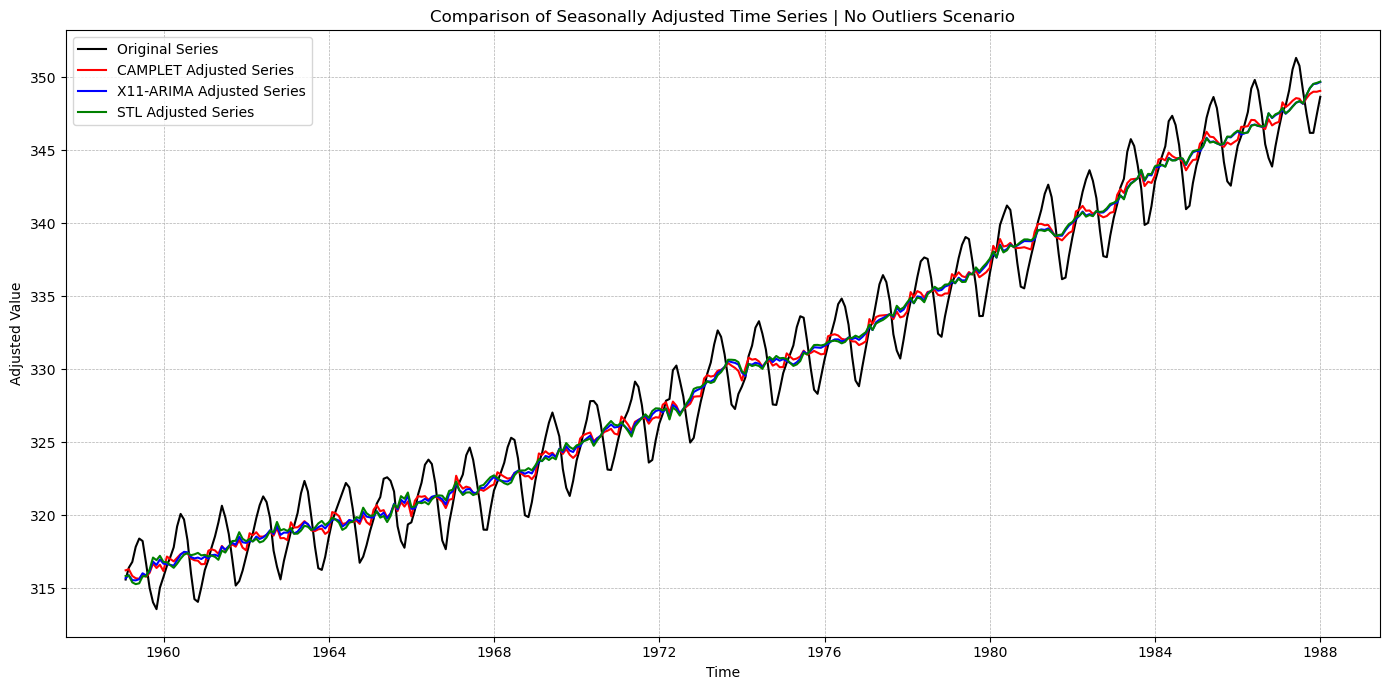

In [4]:
# Plotting 1 
plt.figure(figsize=(14, 7))
plt.plot(DATASET, color="black", label="Original Series")
plt.plot(result_CAMPLET_A.non_seasonal, color="red", label="CAMPLET Adjusted Series")
plt.plot(df_X11_Arima_Naive_A.adjusted_series, color="blue", label="X11-ARIMA Adjusted Series")
plt.plot(df_STL_Naive_A.adjusted_series, color="green", label="STL Adjusted Series")
plt.title('Comparison of Seasonally Adjusted Time Series | No Outliers Scenario')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Adjusted Value')
plt.tight_layout()
plt.show()

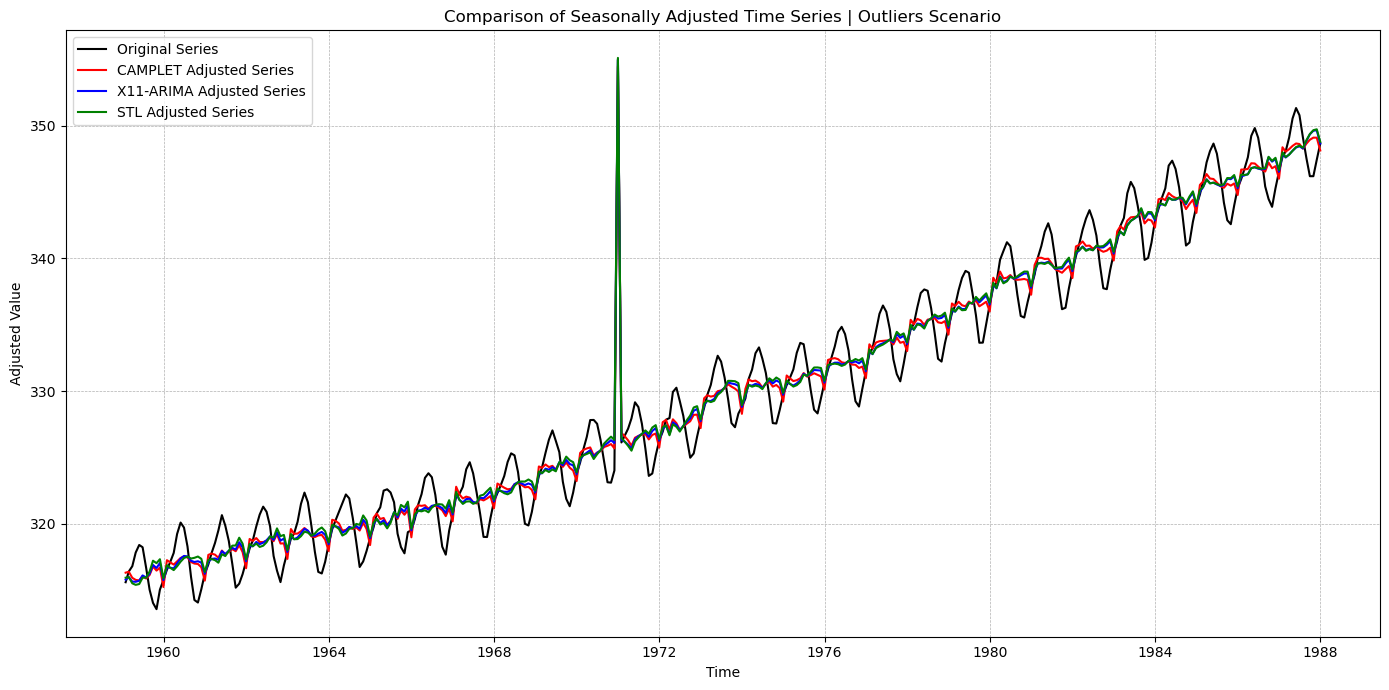

In [5]:
# Plotting 2
plt.figure(figsize=(14, 7))
plt.plot(DATASET_B, color="black", label="Original Series")
plt.plot(result_CAMPLET_B.non_seasonal, color="red", label="CAMPLET Adjusted Series")
plt.plot(df_X11_Arima_Naive_B.adjusted_series, color="blue", label="X11-ARIMA Adjusted Series")
plt.plot(df_STL_Naive_B.adjusted_series, color="green", label="STL Adjusted Series")
plt.title('Comparison of Seasonally Adjusted Time Series | Outliers Scenario')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Adjusted Value')
plt.tight_layout()
plt.show()

## Rerefences

- **Papers**:
    - Abeln, B., & Jacobs, J. P. A. M. (2022). COVID-19 and Seasonal Adjustment. Journal of Business Cycle Research, 18, 159–169. https://doi.org/10.1007/s41549-022-00071-z.
    - Statistics Denmark. (2020). *Statistics on Georgia*. Retrieved from [https://www.dst.dk/Site/Dst/SingleFiles/GetArchiveFile.aspx?fi=2178087769&fo=0&ext=georgia](https://www.dst.dk/Site/Dst/SingleFiles/GetArchiveFile.aspx?fi=2178087769&fo=0&ext=georgia)

- **Complementary resources**:

    - Brownlee, J. (n.d.). *Time Series Seasonality with Python*. Machine Learning Mastery. Retrieved from [https://machinelearningmastery.com/time-series-seasonality-with-python/](https://machinelearningmastery.com/time-series-seasonality-with-python/)
    - CAMPLET. (n.d.). *CAMPLET in a Nutshell*. Retrieved from [http://www.camplet.net/camplet-in-a-nutshell/](http://www.camplet.net/camplet-in-a-nutshell/)
    - CAMPLET Repository. Google Drive. Retrieved from [https://drive.google.com/drive/folders/1gqqE0o52CX6ic-CfEpquFfCfZ2OoY57i](https://drive.google.com/drive/folders/1gqqE0o52CX6ic-CfEpquFfCfZ2OoY57i)
    - Cowpertwait, P. S. P., & Metcalfe, A. V. (2009). *Introductory Time Series with R* (Use R!). Springer. ISBN: 0387886974.
    - CrossValidated contributors. (n.d.). Intuitive explanation of stationarity. In CrossValidated. Retrieved from [https://stats.stackexchange.com/questions/9951/intuitive-explanation-of-stationarity](https://stats.stackexchange.com/questions/9951/intuitive-explanation-of-stationarity)
    - Halls-Moore, M. (2016). *Advanced Algorithmic Trading*. Goodreads. Retrieved from [https://www.goodreads.com/book/show/29005550-advanced-algorithmic-trading](https://www.goodreads.com/book/show/29005550-advanced-algorithmic-trading)
    - Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: principles and practice. Retrieved from [https://otexts.com/fpp2/stationarity.html#fn15](https://otexts.com/fpp2/stationarity.html#fn15)
    - Krishnan, S. (2021, October 18). What is Stationarity in Time Series? How it can be detected? Medium. Retrieved from https://medium.com/codex/what-is-stationarity-in-time-series-how-it-can-be-detected-7e5dfa7b5f6b.    
    - López de Prado, M. (2018). *Advances in Financial Machine Learning*. Hoboken, NJ: Wiley.
    - Mirjalili, S. (2022, July 9). Notebook Archive. Retrieved from [https://notebookarchive.org/2022-07-9nbew3e](https://notebookarchive.org/2022-07-9nbew3e)
    - R-spatial project. (n.d.). *GWR Tricube Method*. Retrieved from [http://rspatial.r-forge.r-project.org/spgwr/reference/gwr.tricube.html](http://rspatial.r-forge.r-project.org/spgwr/reference/gwr.tricube.html)
    - Statsmodels. (n.d.). *statsmodels.nonparametric.smoothers_lowess.lowess*. Retrieved from [https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html)
    - Statsmodels. (n.d.). *statsmodels.tsa.seasonal.STL*. Retrieved from [https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html)
    - Statsmodels. (n.d.). *statsmodels.tsa.x13.x13_arima_analysis*. Retrieved from [https://www.statsmodels.org/dev/generated/statsmodels.tsa.x13.x13_arima_analysis.html](https://www.statsmodels.org/dev/generated/statsmodels.tsa.x13.x13_arima_analysis.html)
    - TutorialsPoint contributors. (n.d.). Signal to Noise Ratio. In TutorialsPoint. Retrieved from [https://www.tutorialspoint.com/statistics/signal_to_noise_ratio.htm](https://www.tutorialspoint.com/statistics/signal_to_noise_ratio.htm)
    - Wikipedia contributors. (n.d.). Seasonal adjustment. In Wikipedia, The Free Encyclopedia. Retrieved from [https://en.wikipedia.org/wiki/Seasonal_adjustment](https://en.wikipedia.org/wiki/Seasonal_adjustment)
    - Wikipedia contributors. (n.d.). Stationary process. In Wikipedia, The Free Encyclopedia. Retrieved from [https://en.wikipedia.org/wiki/Stationary_process](https://en.wikipedia.org/wiki/Stationary_process)
    - Wessa, P. (n.d.). *STL: A Seasonal-Trend Decomposition Procedure Based on Loess*. Retrieved from [https://www.wessa.net/download/stl.pdf](https://www.wessa.net/download/stl.pdf)
    - Ygnacio, Frank. (2022, July 9). *Fractional Differentiation on Long Memory Time Series: A Case of Study in Fractional Brownian Motion Processes*. Notebook Archive. Retrieved from https://notebookarchive.org/2022-07-9nbew3e